# Normalize S2 data using NEON as a reference
step1: prepare S2 data: open S2 safe file in PCI and open 20m bands and export to a tiff file (PCI inlcuding 10m B2,3,4 in 20m as well) (not in the code)<br>
step2: subset 20m S2 using NEON 10m band as a reference using PCI<br>
step3: using GDAL the resampling method to generate 60m data for S2 and NEON in order to smooth the images<br>
step4: using NEON 60m data as the reference and S2 as input to generate linear coefficents using stats.theilslopes<br>
step5: read S2 20m file and normalizing and genereate 20m normalized S2<br>
step6: generate a 20m NEON data using GDAL average resamling method for the comparsion of the normalized S2<br>
step7: verify the normalized result through ploting normalized S2 and NEON 20,  RMSE, SSIM and R2_score.<br>

The code is implemented in an automatics way for all s; for some sites, due to the shape size not the same, an individual procedure is applied in a sepereated section.

In [1]:
# from scipy import interpolate
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score

In [2]:
NEON_dir='F:/neon/normalization/NEON/'
S2_dir='F:/neon/normalization/S2/'

In [3]:
bands_related= [{'band': 'B2', 'NEON':2, 'S2':1}, {'band': 'B3', 'NEON':3, 'S2':2}, {'band': 'B4', 'NEON':4, 'S2':3}, {'band': 'B5', 'NEON':5, 'S2':5}, {'band': 'B6', 'NEON':6, 'S2':6}, 
                {'band': 'B7', 'NEON':7, 'S2':7},  {'band': 'B8', 'NEON':8, 'S2':4},  {'band': 'B8A', 'NEON':9, 'S2':8},  {'band': 'B11', 'NEON':12, 'S2':9},  {'band': 'B12', 'NEON':13, 'S2':10}] 

In [288]:
rows_list_linear = []
rows_list_stats = []
rows_list_norm_stats = []

for file in os.listdir(NEON_dir):
    if file.endswith('10m.tif'):
        site=file.split('_')[2]
        print (site)
        NEON_10m=NEON_dir+file
        S2_20m=S2_dir+'S2_20m_'+site+'.tif'
        NEON_60m=NEON_dir+'NEON_60m_'+site+'.tif'
        NEON_20m=NEON_dir+'NEON_20m_'+site+'.tif'
        S2_20m=S2_dir+'S2_20m_'+site+'.tif'
        S2_60m=S2_dir+'S2_60m_'+site+'.tif'
        print (S2_20m)
        print (NEON_10m)
        print (S2_60m)
        print (NEON_60m)
#         ## generate 60m file to smooth the image
#         raster_rprj1 = gdal.Warp(NEON_60m, NEON_10m, xRes=60, yRes=60, resampleAlg = "average")
#         raster_rprj1 = None
        
        # raster_rprj = gdal.Warp(S2_60m, S2_20m, xRes=60, yRes=60, resampleAlg = "average")
        # raster_rprj = None
        
        # raster_rprj0 = gdal.Warp(NEON_20m, NEON_10m, xRes=20, yRes=20, resampleAlg = "average")
        # raster_rprj0 = None
        ## open 60m file
        ds_S2_60m = gdal.Open(S2_60m)
        ds_NEON_60m = gdal.Open(NEON_60m)
        ds_NEON_20m = gdal.Open(NEON_20m)
        ds_S2_20m = gdal.Open(S2_20m)
           
        ## get the site name, like 'ABBY'
        s_linear={'site': site}  
        s_stats={'site': site} 
        s_norm_stats={'site': site} 
        for ind in bands_related:      
            
            ## get the band name and the corresponding band number in the image file, like B2, NEON:2, S2:1, the index starting from 1
            bandname=ind['band']
            NEON_ind=ind['NEON']
            S2_ind=ind['S2']            
            
            ### get each band from the S2 and NEON files
            S2_B=np.array(ds_S2_60m.GetRasterBand(S2_ind).ReadAsArray())
            NEON_B=np.array(ds_NEON_60m.GetRasterBand(NEON_ind).ReadAsArray())

            S2_B = np.where(S2_B==-9999, np.nan, S2_B)
            NEON_B = np.where(NEON_B==-9999, np.nan, NEON_B)
            S2_B=S2_B/10000
            
            print (NEON_B.shape,'NEON')
            print (S2_B.shape,'S2')

            mask = ~np.isnan(S2_B) & ~np.isnan(NEON_B)
            NEON_B_mask = NEON_B[mask]
            S2_B_mask = S2_B[mask]
            # scipy.stats.theilslopes(y, x=None, alpha=0.95, method='separate')
            # Method to be used for computing estimate for intercept. Following methods are supported,
            # ‘joint’: Uses np.median(y - slope * x) as intercept.
            # ‘separate’: Uses np.median(y) - slope * np.median(x) as intercept.
            # The default is ‘separate’.
            # B3_reg = stats.theilslopes(S2_B3_mask, NEON_B3_mask, 0.90, 'joint')
            B_reg = stats.theilslopes(NEON_B_mask,S2_B_mask, 0.95, 'joint')
                 
            ## generate a dictionary to output the coefficient of linear regression           
            key_slope=bandname+'_slope'
            key_intercept=bandname+'_intercept'
            # print (bandname, NEON_ind, S2_ind) 
            # s2={bandname:{'slope': NEON_ind, 'intercept':S2_ind}}
            s2={key_slope: B_reg[0], key_intercept:B_reg[1]}         
            # s1.update(s2)
            # print (s1)
            s_linear.update(s2)
    
            ## calculate stats before normalization
            key_rmse=bandname+'_RMSE'
            key_ssim=bandname+'_SSIM'
            key_r2=bandname+'_R2'

            # mean_squared_error(y_actual, y_predicted, squared=False)
            RMSE = mean_squared_error(NEON_B_mask,S2_B_mask,squared=False) 
            ## ssim
            # skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
            SSIM = ssim(NEON_B_mask,S2_B_mask,data_range=(S2_B_mask.max()-S2_B_mask.min())) 
            ## R2
            # sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
            R2 = r2_score(NEON_B_mask,S2_B_mask)
            s3={key_rmse: RMSE,  key_ssim:SSIM, key_r2:R2}   
            s_stats.update(s3)  
            
            ## normalize 
            NEON_B_20m=np.array(ds_NEON_20m.GetRasterBand(NEON_ind).ReadAsArray())   
            S2_B_20m=np.array(ds_S2_20m.GetRasterBand(S2_ind).ReadAsArray())  
            print (NEON_B_20m.shape,'NEON_20m')
            print (S2_B_20m.shape,'S2_20m')

            S2_B_20m = np.where(S2_B_20m==-9999, np.nan, S2_B_20m)
            NEON_B_20m = np.where(NEON_B_20m==-9999, np.nan, NEON_B_20m)
            S2_B_20m=S2_B_20m/10000

            NEON_B_20m_2=NEON_B_20m[:S2_B_20m.shape[0],:S2_B_20m.shape[1]]  
            mask = ~np.isnan(S2_B_20m) & ~np.isnan(NEON_B_20m_2)
            NEON_B_20m_mask = NEON_B_20m_2[mask]
            S2_B_20m_mask = S2_B_20m[mask]

            S2_B_norm=S2_B_20m_mask*B_reg[0]+B_reg[1]
              ## nomalize statistics
            key_norm_rmse=bandname+'_norm_RMSE'
            key_norm_ssim=bandname+'_norm_SSIM'
            key_norm_r2=bandname+'_norm_R2'

            # mean_squared_error(y_actual, y_predicted, squared=False)
            RMSE = mean_squared_error(NEON_B_20m_mask,S2_B_norm,squared=False) 
            ## ssim
            # skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
            SSIM = ssim(NEON_B_20m_mask,S2_B_norm,data_range=(S2_B_norm.max()-S2_B_norm.min())) 
            ## R2
            # sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
            R2 = r2_score(NEON_B_20m_mask,S2_B_norm)
            s4={key_norm_rmse: RMSE,  key_norm_ssim:SSIM, key_norm_r2:R2}   
            s_norm_stats.update(s4)          
            ## 
            
        # print (s1)
        rows_list_linear.append(s_linear)
        rows_list_stats.append(s_stats)
        rows_list_norm_stats.append(s_norm_stats)

# df_coe = pd.DataFrame(rows_list)  
# df_coe.to_csv('linearregression_coe.csv')       

HOPB
F:/neon/normalization/S2/S2_20m_HOPB.tif
F:/neon/normalization/NEON/NEON_D01_HOPB_DP1_20190826_172857_reflectance_10m.tif
F:/neon/normalization/S2/S2_60m_HOPB.tif
F:/neon/normalization/NEON/NEON_60m_HOPB.tif
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
(109, 18) NEON
(109, 18) S2
(326, 55) NEON_20m
(326, 55) S2_20m
SERC
F:/neon/normalization/S2/S2_20m_SERC.tif
F:/neon/normalization/NEON/NEON_D02_SERC_DP1_20210811_142655_reflectance_10m.tif
F:/neon/normalizatio

In [284]:
print (rows_list_linear)
print (rows_list_stats)
print (rows_list_norm_stats)

[{'site': 'HOPB', 'B2_slope': 0.6877886227611318, 'B2_intercept': -0.005642428054839072, 'B3_slope': 0.6921616917415376, 'B3_intercept': -0.002064207227980012, 'B4_slope': 0.6768627781269512, 'B4_intercept': -0.004179605566782924, 'B5_slope': 0.6601931872191253, 'B5_intercept': -0.001802841546358895, 'B6_slope': 0.7901759332409563, 'B6_intercept': 0.032488279522086994, 'B7_slope': 0.6683004667630067, 'B7_intercept': 0.029962993906559182, 'B8_slope': 0.5334948492931949, 'B8_intercept': 0.03121626650540954, 'B8A_slope': 0.5290059304060786, 'B8A_intercept': 0.025938994922852565, 'B11_slope': 0.6335498885023747, 'B11_intercept': -0.003047782368158572, 'B12_slope': 0.7220567581741466, 'B12_intercept': -0.00707630546388522}, {'site': 'SERC', 'B2_slope': 0.6640971534781983, 'B2_intercept': -0.01310947433941893, 'B3_slope': 0.7542670766173043, 'B3_intercept': -0.01374954200634302, 'B4_slope': 0.5600714229285164, 'B4_intercept': -0.005299532633508821, 'B5_slope': 0.6449863870154348, 'B5_interce

F:/neon/normalization/S2/S2_20m_STEI.tif
F:/neon/normalization/S2/S2_60m_STEI.tif
F:/neon/normalization/NEON/NEON_60m_STEI.tif
(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


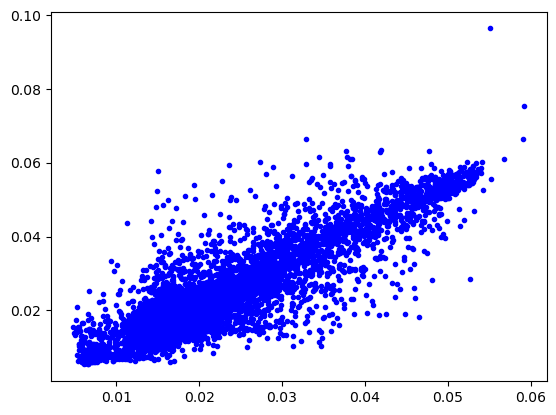

(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


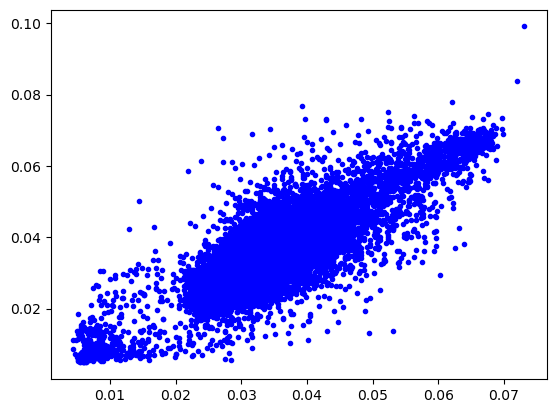

(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


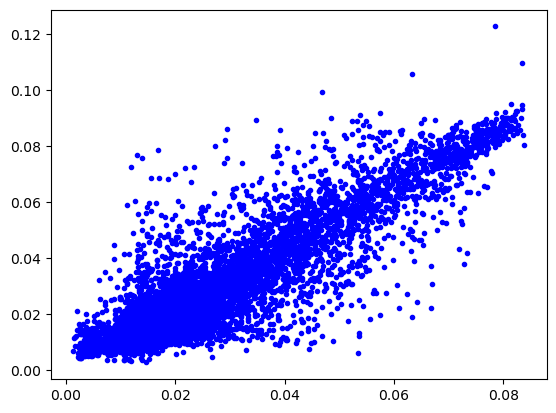

(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


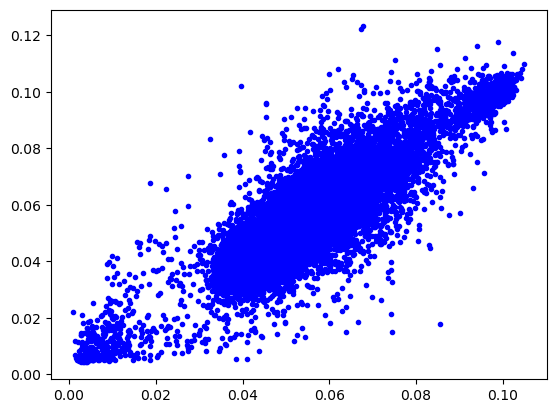

(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


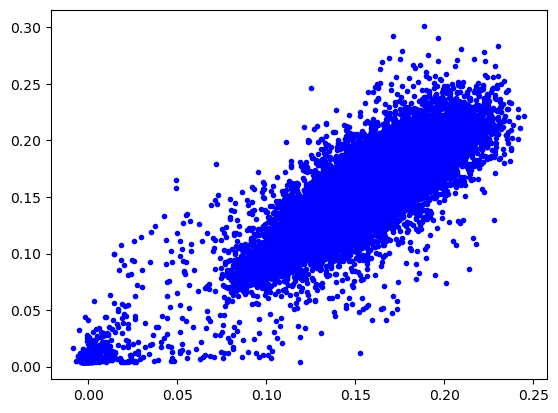

(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


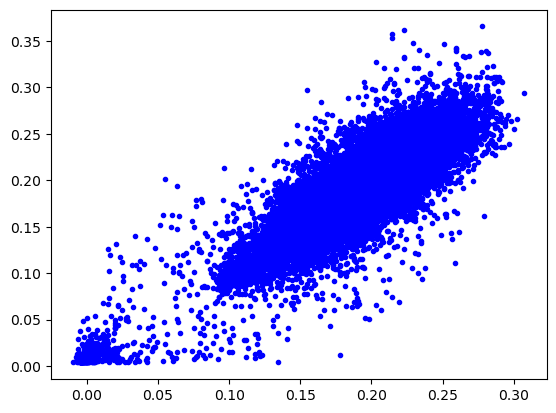

(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


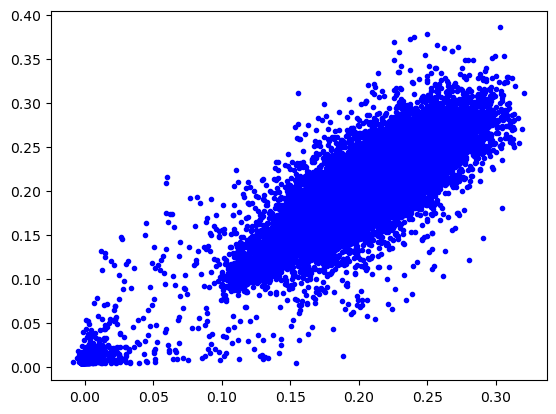

(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


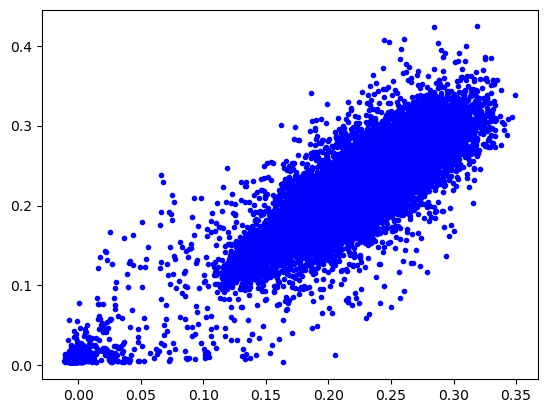

(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


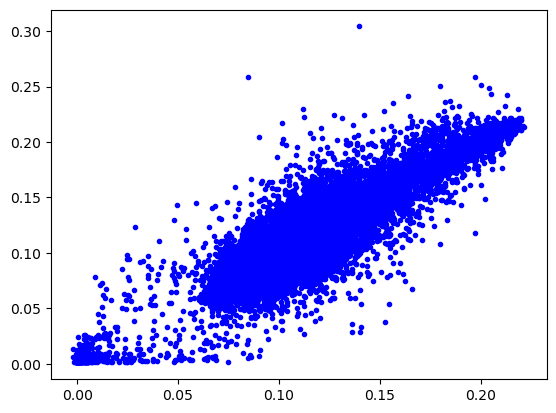

(227, 36) S2
(227, 37) NEON
(680, 110) NEON_20m
(680, 109) S2_20m


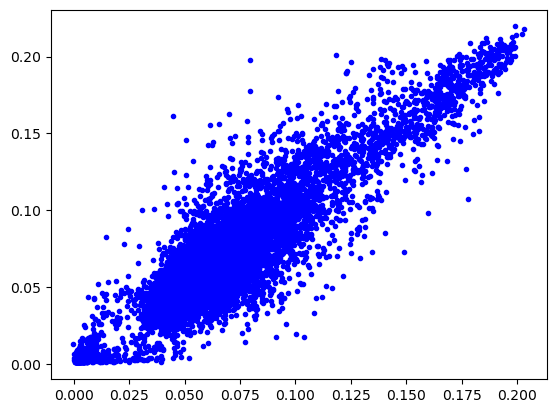

{'site': 'STEI', 'B2_slope': 0.5544592217008577, 'B2_intercept': -0.0008474372014342299, 'B3_slope': 0.549850308924765, 'B3_intercept': 7.400483967950032e-05, 'B4_slope': 0.5677540066721137, 'B4_intercept': -0.0027511549877677934, 'B5_slope': 0.5773685685118789, 'B5_intercept': -0.0035121261534638362, 'B6_slope': 0.5985352882119107, 'B6_intercept': -0.009680331481057403, 'B7_slope': 0.6329007707275711, 'B7_intercept': -0.013923398603300954, 'B8_slope': 0.6349518416093283, 'B8_intercept': -0.011412755310434425, 'B8A_slope': 0.7010531321052562, 'B8A_intercept': -0.016246648285910548, 'B11_slope': 0.6159024478735813, 'B11_intercept': -0.006965877991947242, 'B12_slope': 0.6455427293751302, 'B12_intercept': -0.0031509240105523396}
{'site': 'STEI', 'B2_RMSE': 0.015767254574433405, 'B2_SSIM': 0.6559128202355337, 'B2_R2': -3.912465015735548, 'B3_RMSE': 0.027755229651908547, 'B3_SSIM': 0.633929808008184, 'B3_R2': -8.993197621507663, 'B4_RMSE': 0.019694360837598134, 'B4_SSIM': 0.6574287937057688

In [6]:
## individual site process
# site=file.split('_')[2]
site='STEI'
# NEON_10m=NEON_dir+file
S2_20m=S2_dir+'S2_20m_'+site+'.tif'
NEON_60m=NEON_dir+'NEON_60m_'+site+'.tif'
NEON_20m=NEON_dir+'NEON_20m_'+site+'.tif'
S2_20m=S2_dir+'S2_20m_'+site+'.tif'
S2_60m=S2_dir+'S2_60m_'+site+'.tif'
print (S2_20m)
# print (NEON_10m)
print (S2_60m)
print (NEON_60m)
## generate 60m file to smooth the image
# raster_rprj1 = gdal.Warp(NEON_60m, NEON_10m, xRes=60, yRes=60, resampleAlg = "average")
# raster_rprj1 = None

# raster_rprj = gdal.Warp(S2_60m, S2_20m, xRes=60, yRes=60, resampleAlg = "average")
# raster_rprj = None
## open 60m file
ds_S2_60m = gdal.Open(S2_60m)
ds_S2_20m = gdal.Open(S2_20m)
ds_NEON_60m = gdal.Open(NEON_60m)
ds_NEON_20m = gdal.Open(NEON_20m)

## get the site name, like 'ABBY'
s_linear={'site': site}  
s_stats={'site': site}
s_norm_stats={'site': site}
for ind in bands_related:      

    ## get the band name and the corresponding band number in the image file, like B2, NEON:2, S2:1, the index starting from 1
    bandname=ind['band']
    NEON_ind=ind['NEON']
    S2_ind=ind['S2']            

    ### get each band from the S2 and NEON files
    S2_B=np.array(ds_S2_60m.GetRasterBand(S2_ind).ReadAsArray())
    NEON_B=np.array(ds_NEON_60m.GetRasterBand(NEON_ind).ReadAsArray())
    
    print (S2_B.shape, 'S2')
    print (NEON_B.shape,'NEON')

    S2_B = np.where(S2_B==-9999, np.nan, S2_B)
    NEON_B = np.where(NEON_B==-9999, np.nan, NEON_B)
    S2_B=S2_B/10000

    NEON_B_2=NEON_B[:S2_B.shape[0],:S2_B.shape[1]]
    
    mask = ~np.isnan(S2_B) & ~np.isnan(NEON_B_2)
    NEON_B_mask = NEON_B_2[mask]
    S2_B_mask = S2_B[mask]
    # scipy.stats.theilslopes(y, x=None, alpha=0.95, method='separate')
    # Method to be used for computing estimate for intercept. Following methods are supported,
    # ‘joint’: Uses np.median(y - slope * x) as intercept.
    # ‘separate’: Uses np.median(y) - slope * np.median(x) as intercept.
    # The default is ‘separate’.
    # B3_reg = stats.theilslopes(S2_B3_mask, NEON_B3_mask, 0.90, 'joint')
    # B_reg = stats.theilslopes(NEON_B_mask,S2_B_mask, 0.90, 'joint')
    B_reg = stats.theilslopes(NEON_B_mask,S2_B_mask,0.95, 'joint')

    ## generate a dictionary to output the coefficient of linear regression           
    key_slope=bandname+'_slope'
    key_intercept=bandname+'_intercept'
    # print (bandname, NEON_ind, S2_ind) 
    # s2={bandname:{'slope': NEON_ind, 'intercept':S2_ind}}
    s2={key_slope: B_reg[0], key_intercept:B_reg[1]}         
    s_linear.update(s2)
    
    ## calculate stats before normalization
    
    key_rmse=bandname+'_RMSE'
    key_ssim=bandname+'_SSIM'
    key_r2=bandname+'_R2'
    
    # mean_squared_error(y_actual, y_predicted, squared=False)
    RMSE = mean_squared_error(NEON_B_mask,S2_B_mask,squared=False) 
    ## ssim
    # skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
    SSIM = ssim(NEON_B_mask,S2_B_mask,data_range=(S2_B_mask.max()-S2_B_mask.min())) 
    ## R2
    # sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
    R2 = r2_score(NEON_B_mask,S2_B_mask)
    s3={key_rmse: RMSE,  key_ssim:SSIM, key_r2:R2}   
    s_stats.update(s3)     
    
   
    NEON_B_20m=np.array(ds_NEON_20m.GetRasterBand(NEON_ind).ReadAsArray())   
    S2_B_20m=np.array(ds_S2_20m.GetRasterBand(S2_ind).ReadAsArray())  
    print (NEON_B_20m.shape,'NEON_20m')
    print (S2_B_20m.shape,'S2_20m')
    
    S2_B_20m = np.where(S2_B_20m==-9999, np.nan, S2_B_20m)
    NEON_B_20m = np.where(NEON_B_20m==-9999, np.nan, NEON_B_20m)
    S2_B_20m=S2_B_20m/10000
    
    NEON_B_20m_2=NEON_B_20m[:S2_B_20m.shape[0],:S2_B_20m.shape[1]]  
    mask = ~np.isnan(S2_B_20m) & ~np.isnan(NEON_B_20m_2)
    NEON_B_20m_mask = NEON_B_20m_2[mask]
    S2_B_20m_mask = S2_B_20m[mask]
    
    S2_B_norm=S2_B_20m_mask*B_reg[0]+B_reg[1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
    # ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
    ax.plot(S2_B_norm,NEON_B_20m_mask, 'b.')
    # ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
    plt.show()
      ## nomalize statistics
    key_norm_rmse=bandname+'_norm_RMSE'
    key_norm_ssim=bandname+'_norm_SSIM'
    key_norm_r2=bandname+'_norm_R2'
    
    # mean_squared_error(y_actual, y_predicted, squared=False)
    RMSE = mean_squared_error(NEON_B_20m_mask,S2_B_norm,squared=False) 
    ## ssim
    # skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
    SSIM = ssim(NEON_B_20m_mask,S2_B_norm,data_range=(S2_B_norm.max()-S2_B_norm.min())) 
    ## R2
    # sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
    R2 = r2_score(NEON_B_20m_mask,S2_B_norm)
    s4={key_norm_rmse: RMSE,  key_norm_ssim:SSIM, key_norm_r2:R2}   
    s_norm_stats.update(s4)
    
print (s_linear)
print (s_stats)
print (s_norm_stats)

In [290]:
## combine dictionaries
# rows_list.append(s1)
rows_list_stats.append(s_stats)
rows_list_norm_stats.append(s_norm_stats)
rows_list_linear.append(s_linear)

# make a dataframe
df_stats = pd.DataFrame(rows_list_stats)  
df_norm_stats = pd.DataFrame(rows_list_norm_stats)  
df_linear = pd.DataFrame(rows_list_linear) 
df_stats.to_csv('stats2.csv')       
df_linear.to_csv('linear2.csv') 
df_norm_stats.to_csv('norm2.csv') 

F:/neon/normalization/S2/S2_20m_SERC.tif
F:/neon/normalization/S2/S2_60m_SERC.tif
F:/neon/normalization/NEON/NEON_60m_SERC.tif
Before norm {'B2_RMSE': 0.026867929521004953, 'B2_SSIM': 0.4522334310562652, 'B2_R2': -10.397906175511624}


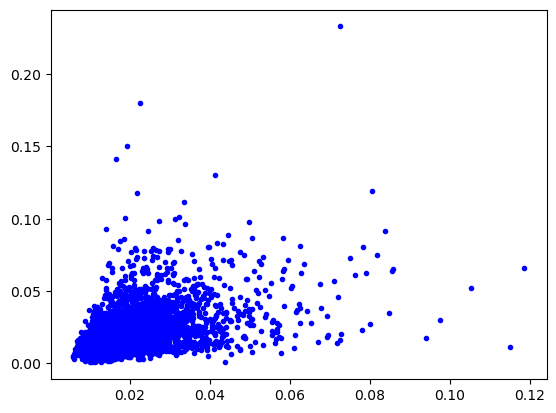

After norm {'B2_norm_RMSE': 0.008262791229472478, 'B2_norm_SSIM': 0.5800743939983299, 'B2_norm_R2': 0.3483159346803655}
**************************************************************************************
Before norm {'B3_RMSE': 0.0281984242033925, 'B3_SSIM': 0.5533541577125435, 'B3_R2': -5.232164045509245}


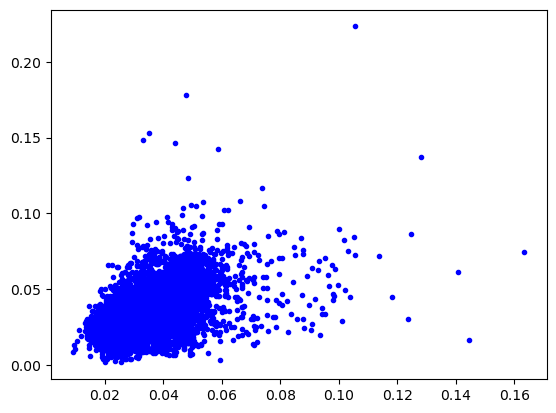

After norm {'B3_norm_RMSE': 0.01071853584147709, 'B3_norm_SSIM': 0.46278921005452883, 'B3_norm_R2': 0.3641885871844418}
**************************************************************************************
Before norm {'B4_RMSE': 0.02220303006970172, 'B4_SSIM': 0.5356664493788527, 'B4_R2': -4.1727264295490905}


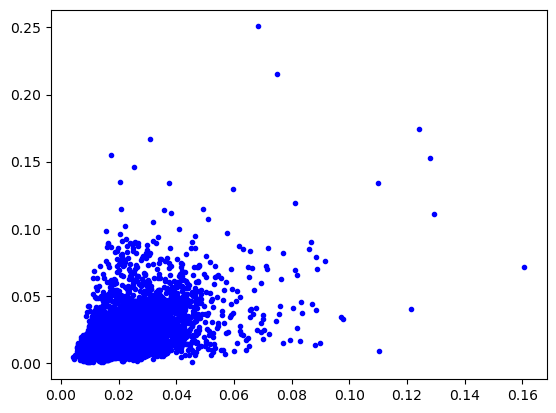

After norm {'B4_norm_RMSE': 0.009838671189163853, 'B4_norm_SSIM': 0.6400502668306032, 'B4_norm_R2': 0.390758776211105}
**************************************************************************************
Before norm {'B5_RMSE': 0.04298699203031155, 'B5_SSIM': 0.5485788019108006, 'B5_R2': -7.334346246351979}


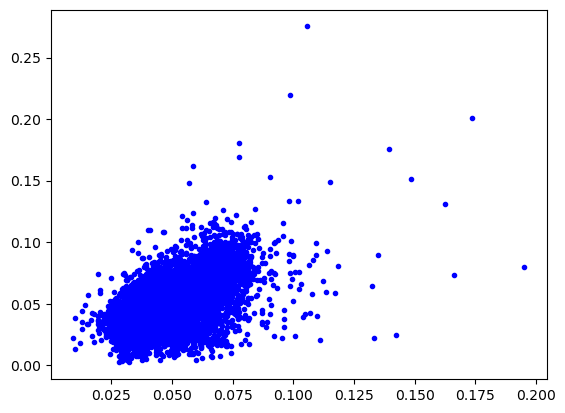

After norm {'B5_norm_RMSE': 0.013569404244994554, 'B5_norm_SSIM': 0.4208125581870914, 'B5_norm_R2': 0.41386369253077604}
**************************************************************************************
Before norm {'B6_RMSE': 0.060109321802702245, 'B6_SSIM': 0.3882368176627286, 'B6_R2': -0.8325538658750371}


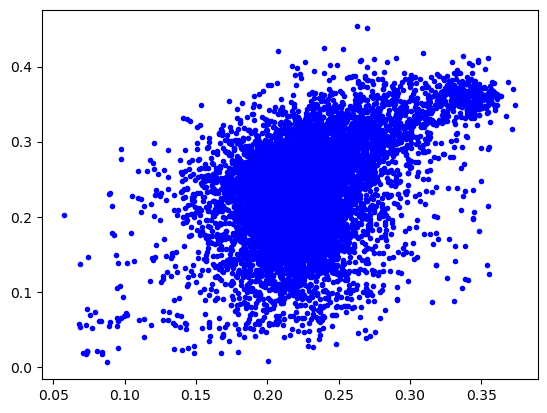

After norm {'B6_norm_RMSE': 0.051700558874639854, 'B6_norm_SSIM': 0.11053512620192517, 'B6_norm_R2': 0.18596806748722405}
**************************************************************************************
Before norm {'B7_RMSE': 0.12124010235121527, 'B7_SSIM': 0.4230509100802692, 'B7_R2': -5.156016143413903}


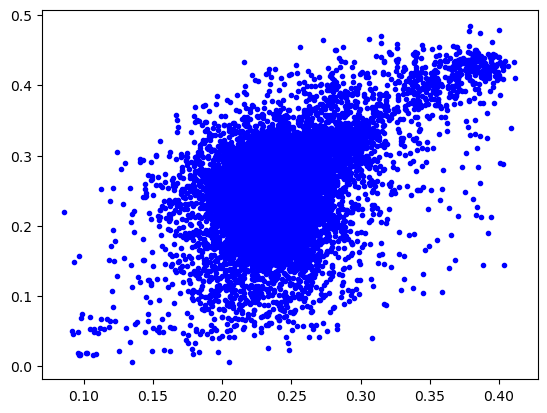

After norm {'B7_norm_RMSE': 0.05454623855759333, 'B7_norm_SSIM': 0.11624369355859532, 'B7_norm_R2': 0.2556373308178721}
**************************************************************************************
Before norm {'B8_RMSE': 0.1584905639252663, 'B8_SSIM': 0.3908374619708108, 'B8_R2': -14.178064410028469}


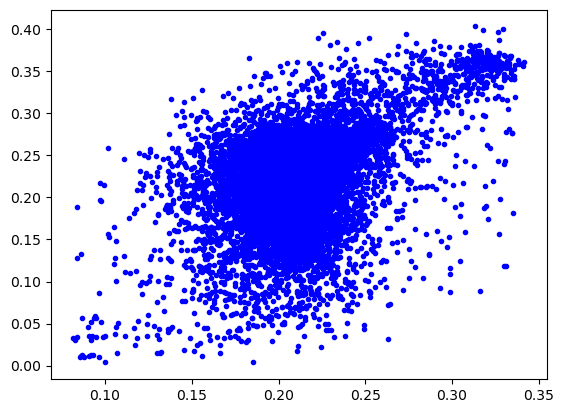

After norm {'B8_norm_RMSE': 0.04748777770837489, 'B8_norm_SSIM': 0.07193776019320698, 'B8_norm_R2': 0.20319762300855193}
**************************************************************************************
Before norm {'B8A_RMSE': 0.18358167698369354, 'B8A_SSIM': 0.38114583763702226, 'B8A_R2': -20.139913837013204}


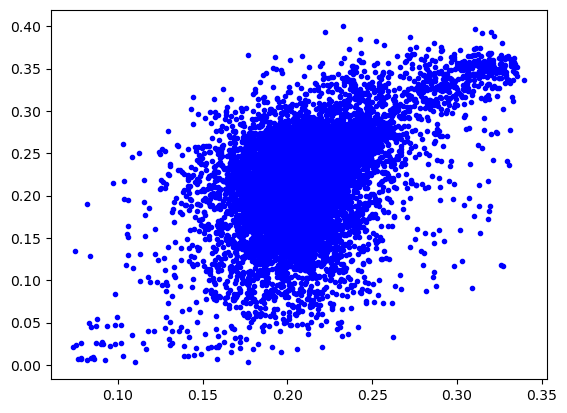

After norm {'B8A_norm_RMSE': 0.04583016052980368, 'B8A_norm_SSIM': 0.11358430693114682, 'B8A_norm_R2': 0.23594302145924706}
**************************************************************************************
Before norm {'B11_RMSE': 0.09425512455064004, 'B11_SSIM': 0.5036862229938991, 'B11_R2': -12.482925611577413}


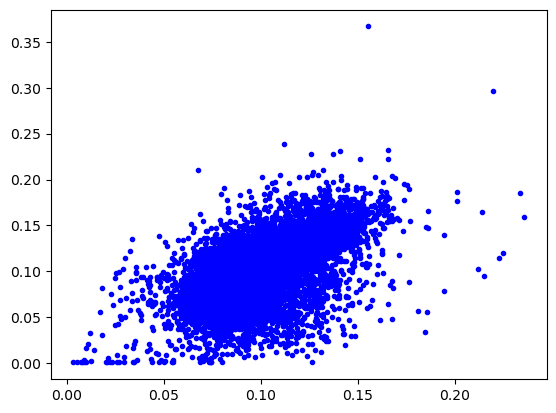

After norm {'B11_norm_RMSE': 0.024650611156584835, 'B11_norm_SSIM': 0.3293166968317715, 'B11_norm_R2': 0.3888810423980972}
**************************************************************************************
Before norm {'B12_RMSE': 0.04661738178989193, 'B12_SSIM': 0.5562865744647024, 'B12_R2': -7.328495451453239}


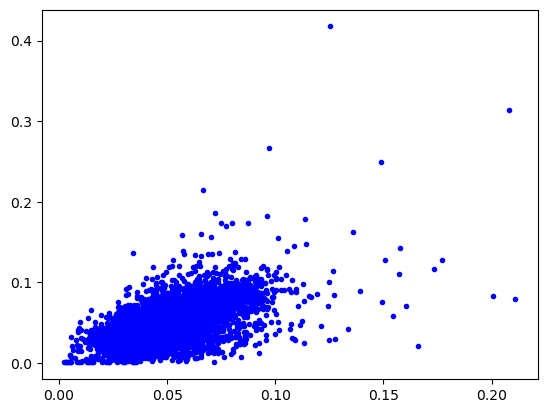

After norm {'B12_norm_RMSE': 0.014727719594237014, 'B12_norm_SSIM': 0.4944541679684961, 'B12_norm_R2': 0.45645207497115814}
**************************************************************************************
Linear regression coefficients:
{'site': 'SERC', 'B2_slope': 0.6640971534781983, 'B2_intercept': -0.01310947433941893, 'B3_slope': 0.7542670766173043, 'B3_intercept': -0.01374954200634302, 'B4_slope': 0.5600714229285164, 'B4_intercept': -0.005299532633508821, 'B5_slope': 0.6449863870154348, 'B5_intercept': -0.011807094009495096, 'B6_slope': 0.7361352853348982, 'B6_intercept': 0.022497865649842796, 'B7_slope': 0.5176165544776874, 'B7_intercept': 0.05715166344583916, 'B8_slope': 0.41619632758197056, 'B8_intercept': 0.05805734502384366, 'B8A_slope': 0.3983869590961682, 'B8A_intercept': 0.0545179071683477, 'B11_slope': 0.5295872688293453, 'B11_intercept': -0.005610793828964185, 'B12_slope': 0.509989231102016, 'B12_intercept': -0.0022260627162244244}
Statistic comparison before norma

In [11]:
## individual site process
# site=file.split('_')[2]
site='SERC'
# NEON_10m=NEON_dir+file
S2_20m=S2_dir+'S2_20m_'+site+'.tif'
NEON_60m=NEON_dir+'NEON_60m_'+site+'.tif'
NEON_20m=NEON_dir+'NEON_20m_'+site+'.tif'
S2_20m=S2_dir+'S2_20m_'+site+'.tif'
S2_60m=S2_dir+'S2_60m_'+site+'.tif'
print (S2_20m)
# print (NEON_10m)
print (S2_60m)
print (NEON_60m)
## generate 60m file to smooth the image
# raster_rprj1 = gdal.Warp(NEON_60m, NEON_10m, xRes=60, yRes=60, resampleAlg = "average")
# raster_rprj1 = None

# raster_rprj = gdal.Warp(S2_60m, S2_20m, xRes=60, yRes=60, resampleAlg = "average")
# raster_rprj = None
## open 60m file
ds_S2_60m = gdal.Open(S2_60m)
ds_S2_20m = gdal.Open(S2_20m)
ds_NEON_60m = gdal.Open(NEON_60m)
ds_NEON_20m = gdal.Open(NEON_20m)

## get the site name, like 'ABBY'
s_linear={'site': site}  
s_stats={'site': site}
s_norm_stats={'site': site}
for ind in bands_related:      

    ## get the band name and the corresponding band number in the image file, like B2, NEON:2, S2:1, the index starting from 1
    bandname=ind['band']
    NEON_ind=ind['NEON']
    S2_ind=ind['S2']            

    ### get each band from the S2 and NEON files
    S2_B=np.array(ds_S2_60m.GetRasterBand(S2_ind).ReadAsArray())
    NEON_B=np.array(ds_NEON_60m.GetRasterBand(NEON_ind).ReadAsArray())
    
    # print (S2_B.shape, 'S2')
    # print (NEON_B.shape,'NEON')

    S2_B = np.where(S2_B==-9999, np.nan, S2_B)
    NEON_B = np.where(NEON_B==-9999, np.nan, NEON_B)
    S2_B=S2_B/10000

    NEON_B_2=NEON_B[:S2_B.shape[0],:S2_B.shape[1]]
    
    mask = ~np.isnan(S2_B) & ~np.isnan(NEON_B_2)
    NEON_B_mask = NEON_B_2[mask]
    S2_B_mask = S2_B[mask]
    # scipy.stats.theilslopes(y, x=None, alpha=0.95, method='separate')
    # Method to be used for computing estimate for intercept. Following methods are supported,
    # ‘joint’: Uses np.median(y - slope * x) as intercept.
    # ‘separate’: Uses np.median(y) - slope * np.median(x) as intercept.
    # The default is ‘separate’.
    # B3_reg = stats.theilslopes(S2_B3_mask, NEON_B3_mask, 0.90, 'joint')
    # B_reg = stats.theilslopes(NEON_B_mask,S2_B_mask, 0.90, 'joint')
    B_reg = stats.theilslopes(NEON_B_mask,S2_B_mask,0.95, 'joint')

    ## generate a dictionary to output the coefficient of linear regression           
    key_slope=bandname+'_slope'
    key_intercept=bandname+'_intercept'
    # print (bandname, NEON_ind, S2_ind) 
    # s2={bandname:{'slope': NEON_ind, 'intercept':S2_ind}}
    s2={key_slope: B_reg[0], key_intercept:B_reg[1]}         
    s_linear.update(s2)
    
    ## calculate stats before normalization
    
    key_rmse=bandname+'_RMSE'
    key_ssim=bandname+'_SSIM'
    key_r2=bandname+'_R2'
    
    # mean_squared_error(y_actual, y_predicted, squared=False)
    RMSE = mean_squared_error(NEON_B_mask,S2_B_mask,squared=False) 
    ## ssim
    # skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
    SSIM = ssim(NEON_B_mask,S2_B_mask,data_range=(S2_B_mask.max()-S2_B_mask.min())) 
    ## R2
    # sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
    R2 = r2_score(NEON_B_mask,S2_B_mask)
    s3={key_rmse: RMSE,  key_ssim:SSIM, key_r2:R2}   
    s_stats.update(s3)
    print ('Before norm',s3)
    
   
    
   
    NEON_B_20m=np.array(ds_NEON_20m.GetRasterBand(NEON_ind).ReadAsArray())   
    S2_B_20m=np.array(ds_S2_20m.GetRasterBand(S2_ind).ReadAsArray())  
    # print (NEON_B_20m.shape,'NEON_20m')
    # print (S2_B_20m.shape,'S2_20m')
    
    S2_B_20m = np.where(S2_B_20m==-9999, np.nan, S2_B_20m)
    NEON_B_20m = np.where(NEON_B_20m==-9999, np.nan, NEON_B_20m)
    S2_B_20m=S2_B_20m/10000
    
    NEON_B_20m_2=NEON_B_20m[:S2_B_20m.shape[0],:S2_B_20m.shape[1]]  
    mask = ~np.isnan(S2_B_20m) & ~np.isnan(NEON_B_20m_2)
    NEON_B_20m_mask = NEON_B_20m_2[mask]
    S2_B_20m_mask = S2_B_20m[mask]
    
    S2_B_norm=S2_B_20m_mask*B_reg[0]+B_reg[1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
    # ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
    ax.plot(S2_B_norm,NEON_B_20m_mask, 'b.')
    # ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
    plt.show()
      ## nomalize statistics
    key_norm_rmse=bandname+'_norm_RMSE'
    key_norm_ssim=bandname+'_norm_SSIM'
    key_norm_r2=bandname+'_norm_R2'
    
    # mean_squared_error(y_actual, y_predicted, squared=False)
    RMSE = mean_squared_error(NEON_B_20m_mask,S2_B_norm,squared=False) 
    ## ssim
    # skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
    SSIM = ssim(NEON_B_20m_mask,S2_B_norm,data_range=(S2_B_norm.max()-S2_B_norm.min())) 
    ## R2
    # sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
    R2 = r2_score(NEON_B_20m_mask,S2_B_norm)
    s4={key_norm_rmse: RMSE,  key_norm_ssim:SSIM, key_norm_r2:R2}   
    s_norm_stats.update(s4)
    print ('After norm',s4)
    print ('**************************************************************************************')
print ('Linear regression coefficients:')    
print (s_linear)
print ('Statistic comparison before normalization:')   
print (s_stats)
print ('Statistic comparison after normalization:')
print (s_norm_stats)